In [1]:
import numpy as np
import scipy as sp
import os
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
os.makedirs("data/add_pts", exist_ok=True)

In [4]:
def eps_rank_experiement(lam,Ks,n_samples,added_support,added_weight):
    n = len(lam)
    A = sp.sparse.spdiags(np.hstack([lam,added_support]),0,n+len(added_support),n+len(added_support))    
    
    lb,ub = np.min(lam),np.max(lam)

    GQ = {k:[] for k in Ks}
    GQ_lower = {k:[] for k in Ks}
    GQ_upper = {k:[] for k in Ks}

    weights = {k:np.zeros((n_samples,k)) for k in Ks}

    vs = []

    v2_ave = np.zeros(n+len(added_support))

    np.random.seed(0) # for reproducibility and consistency across experimetns
    for i in range(n_samples):

        v = np.random.randn(n)
        v /= np.linalg.norm(v)

        v = np.hstack([v,added_weight])
        v2_ave += v**2

        Q,(a_,b_) = exact_lanczos(A,v,max(Ks),reorth=True)

        for k in Ks:

            # define Gaussian quadrature
            GQ[k].append(get_GQ_distr(a_[:k],b_[:k-1],norm2=np.sum(v**2)))
            weights[k][i] = GQ[k][-1].weights

            # define upper and lower bounds
            GQ_lower[k].append(get_GQ_lower_bound(GQ[k][-1],lb,ub))
            GQ_upper[k].append(get_GQ_upper_bound(GQ[k][-1],lb,ub))

    v2_ave /= n_samples

    GQ_ave = {}
    GQ_lower_ave = {}
    GQ_upper_ave = {}

    for k in Ks:
       # average bounds
        GQ_ave[k] = get_ave_distr(GQ[k])
        GQ_lower_ave[k] = get_ave_distr(GQ_lower[k])
        GQ_upper_ave[k] = get_ave_distr(GQ_upper[k]) 
        
    return n_samples,v2_ave,GQ_ave,GQ_lower_ave,GQ_upper_ave

In [5]:
problems = [{'name':'California',
             'Ks':np.arange(1,300,dtype=np.int),
             'n_samples':22,
             'added_support':np.array([]),
             'added_weight':np.array([]),
             'x':1e-1,
            },
            {'name':'California',
             'Ks':np.arange(1,300,dtype=np.int),
             'n_samples':22,
             'added_support':np.array([5e-2]),
             'added_weight':np.array([np.sqrt(.005/2)]),
             'x':1e-1,
             'notes':'_addpts'
            },
            {'name':'California',
             'Ks':np.arange(1,300,dtype=np.int),
             'n_samples':22,
             'added_support':np.array([5e-2]),
             'added_weight':np.array([np.sqrt(.005*10)]),
             'x':1e-1,
             'notes':'_addpts1'
            }]

In [6]:
if True:
    for problem in problems:
        name = problem['name']

        Ks = problem['Ks']
        n_samples = problem['n_samples']

        added_support = problem['added_support']
        added_weight = problem['added_weight']

        try:
            notes = problem['notes']
        except:
            notes = ''

        print(f'{name}{notes}')
        lam = np.load(f"matrices/{name}_eigs.npy")
        n = len(lam)

        np.save(f'data/add_pts/{name}{notes}',eps_rank_experiement(lam,Ks,n_samples,added_support,added_weight),allow_pickle=True)

California
California_addpts
California_addpts1


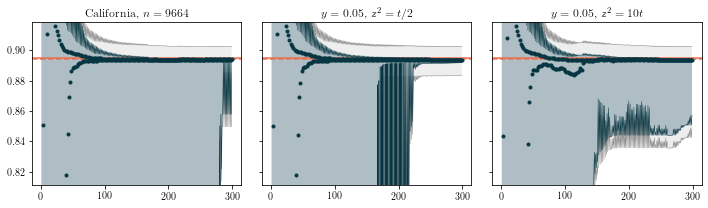

In [7]:
fig,axs = plt.subplots(1,3,figsize=(12,3),sharey=True)
fig.subplots_adjust(wspace=.1)


for i,problem in enumerate(problems):
    name = problem['name']
    Ks = problem['Ks']

    try:
        notes = problem['notes']
    except:
        notes = ''
        
    added_support = problem['added_support']
    added_weight = problem['added_weight']

    lam = np.load(f"matrices/{name}_eigs.npy")
    n = len(lam)

    x = problem['x']
    n = len(lam)
    
    def adjust_distr(x):
        return np.sum(added_weight[added_support<=x]**2)

    n_samples,v2_ave,GQ_ave,GQ_lower_ave,GQ_upper_ave = np.load(f'data/add_pts/{name}{notes}.npy',allow_pickle=True)
  
    eta = 0.01
    eps = np.sqrt( (n+2)**(-1) * n_samples**(-1) * np.log(2*n/(eta)) )

    
    GQ_vals = np.array([GQ_ave[k](x)-adjust_distr(x) for k in Ks])
    GQ_upper_vals = np.array([GQ_upper_ave[k](x)-adjust_distr(x) for k in Ks])
    GQ_lower_vals = np.array([GQ_lower_ave[k](x)-adjust_distr(x) for k in Ks])
    GQ_upper_eps_vals = np.array([np.clip(GQ_upper_ave[k](x)-adjust_distr(x)+eps,0,1) for k in Ks])
    GQ_lower_eps_vals = np.array([np.clip(GQ_lower_ave[k](x)-adjust_distr(x)-eps,0,1) for k in Ks])

#    GQ_upper_vals = np.maximum.accumulate(GQ_upper_vals[::-1])[::-1]
#    GQ_lower_vals = np.maximum.accumulate(GQ_lower_vals)
#    GQ_upper_eps_vals = np.maximum.accumulate(GQ_upper_eps_vals[::-1])[::-1]
#    GQ_lower_eps_vals = np.maximum.accumulate(GQ_lower_eps_vals)

    
    true_val = np.count_nonzero(lam<x)/n #np.count_nonzero((lam<eps_upper)*(lam>eps_lower))/n
    sample_val = np.sum(v2_ave[:n][lam<x])

    v_offset = 0#sample_val

    axs[i].axhline(true_val-v_offset,color='#E76F51')
    axs[i].axhline(sample_val-v_offset,color='#E76F51',ls='--')
    
    axs[i].plot(Ks,GQ_vals-v_offset,ls='None',marker='.',color='#073642')

    axs[i].fill_between(Ks,GQ_upper_eps_vals-v_offset,GQ_lower_eps_vals-v_offset,facecolor='#eeeeee')
    axs[i].plot(Ks,GQ_upper_eps_vals-v_offset,ls='-',lw=.5,marker='None',color='#888888')
    axs[i].plot(Ks,GQ_lower_eps_vals-v_offset,ls='-',lw=.5,marker='None',color='#888888')
    
    axs[i].fill_between(Ks,GQ_upper_vals-v_offset,GQ_lower_vals-v_offset,facecolor='#afbec4')
    axs[i].plot(Ks,GQ_upper_vals-v_offset,ls='-',lw=.5,marker='None',color='#073642')
    axs[i].plot(Ks,GQ_lower_vals-v_offset,ls='-',lw=.5,marker='None',color='#073642')


axs[0].set_title(f"{name.replace('_',' ')}, $n={n}$")#, $x={x}$, $n_{{\mathrm{{v}}}}={n_samples}$, $t={eps}$")
axs[1].set_title(f'$y=0.05$, $z^2=t/2$')
axs[2].set_title(f'$y=0.05$, $z^2=10t$')


axs[0].set_ylim(sample_val-v_offset-10*eps,sample_val-v_offset+3*eps)

plt.savefig('imgs/epsrank_bounds_added_pts.pdf',bbox_inches='tight')